# Learning Scikit-learn: Machine Learning in Python

## IPython Notebook for Chapter 3: Unsupervised Learning - Clustering Handwritten Digits

_Clustering involves finding groups where all elements in the group are similar, but objects in different groups are not. K-means is the most popular clustering algorithm, because it is very simple and easy to implement and it has shown good performance on different tasks. We will show in this notebook how k-means works using a motivating example, the problem of clustering handwritten digits. At the end of the notebook, we will try other, different, clustering approaches to the same problem _


Start by importing numpy, scikit-learn, and pyplot, the Python libraries we will be using in this chapter. Show the versions we will be using (in case you have problems running the notebooks).

In [1]:
%pylab inline
import IPython
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print('IPython version:', IPython.__version__)
print('numpy version:', np.__version__)
print('scikit-learn version:', sk.__version__)
print('matplotlib version:', matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
IPython version: 6.1.0
numpy version: 1.13.1
scikit-learn version: 0.18.2
matplotlib version: 2.0.2


Import the digits dataset (http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html) and show some of its instances

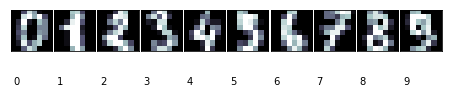

In [3]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
digits = load_digits()
data = scale(digits.data)

def print_digits(images,y,max_n=10):
    # set up the figure size in inches
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    i = 0
    while i < max_n and i < images.shape[0]:
        # plot the images in a matrix of 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        # label the image with the target value
        p.text(0, 14, str(y[i]))
        i = i + 1
    
print_digits(digits.images, digits.target, max_n=10)


Build training and test set

n_digits: 10, 	 n_samples 1347, 	 n_features 64


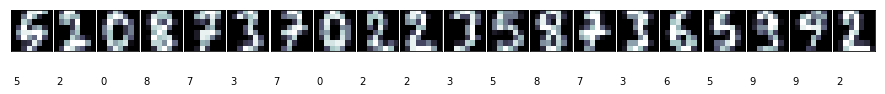

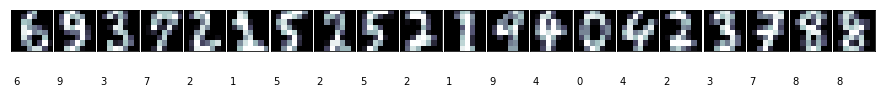

In [9]:
# Training and test set
from sklearn.cross_validation import train_test_split

number_of_instances=digits.images.shape[0]
# Since from scikit-learn 0.15.1 train_test_split only admits dim=2 arrays
# We have to reshape images
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(
        data, digits.target, digits.images.reshape(number_of_instances,64),test_size=0.25, random_state=42)

n_samples, n_features = X_train.shape
n_digits = len(np.unique(y_train))
labels = y_train

# Reshape images back
images_train=images_train.reshape(images_train.shape[0],8,8)
images_test=images_test.reshape(images_test.shape[0],8,8)


print_digits(images_train, y_train, max_n=20)
print_digits(images_test, y_test, max_n=20)

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


## K-Means

The main idea behind k-means is to find a partition of data points such that the squared distance between the cluster mean and each point in the cluster is minimized. Note that this method assumes that you know a priori the number of clusters your data should be divided into. Train a KMeans classifier, show the clusters. 

(1347,)
[3 2 0 6 8 6 2 3 3]


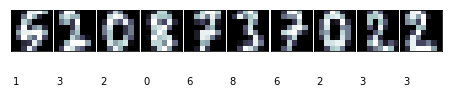

In [10]:
from sklearn import cluster
clf = cluster.KMeans(init='k-means++', n_clusters=10, random_state=42)
clf.fit(X_train)
print (clf.labels_.shape)
print (clf.labels_[1:10])
print_digits(images_train, clf.labels_, max_n=10)


To predict the clusters for training data, we use the usual predict method of the classifier. Predict and show predicted clusters.

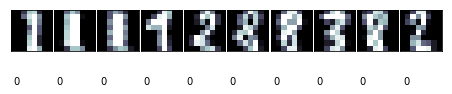

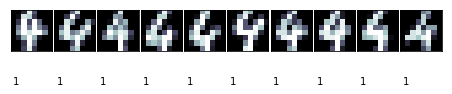

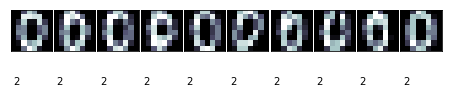

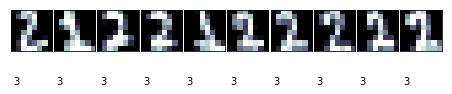

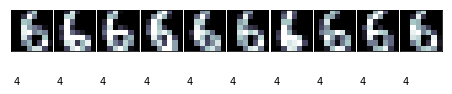

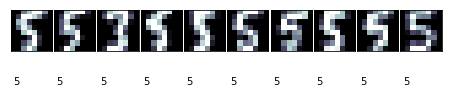

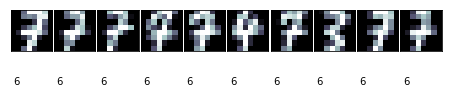

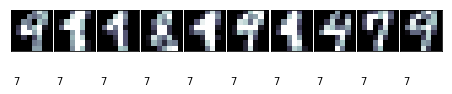

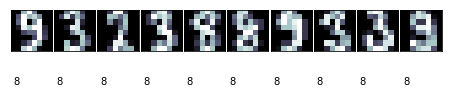

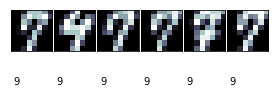

In [11]:
# Predict clusters on testing data
y_pred = clf.predict(X_test)

def print_cluster(images, y_pred, cluster_number):
    images = images[y_pred==cluster_number]
    y_pred = y_pred[y_pred==cluster_number]
    print_digits(images, y_pred, max_n=10)

for i in range(10):
     print_cluster(images_test, y_pred, i)


How can we evaluate our performance? Precision and all that stuff does not work, since we have no target classes to compare with. To evaluate, we need to know the "real" clusters, whatever that means. We can suppose, for our example, that each cluster includes every drawing of a certain number, and only that number. Knowing this, we can compute the adjusted Rand index between our cluster assignment and the expected one. The Rand index is a similar measure for accuracy, but it takes into account the fact that classes can have different names in both assignments. That is, if we change class names, the index does not change. The adjusted index tries to deduct from the result coincidences that have occurred by chance. When you have the exact same clusters in both sets, the Rand index equals one, while it equals zero when there are no clusters sharing a data point. Show different performance metrics, compared with "original" clusters (using the knowb number class)

In [30]:
from sklearn import metrics
print ("Addjusted rand score:{:.2}".format(metrics.adjusted_rand_score(y_test, y_pred)))
print ("Homogeneity score:{:.2} ".format(metrics.homogeneity_score(y_test, y_pred)) )
print ("Completeness score: {:.2} ".format(metrics.completeness_score(y_test, y_pred)))
print ("Confusion matrix")
print (metrics.confusion_matrix(y_test, y_pred))

Addjusted rand score:0.65
Homogeneity score:0.75 
Completeness score: 0.8 
Confusion matrix
[[ 0  0 43  0  0  0  0  0  0  0]
 [19  0  0  7  0  0  0 11  0  0]
 [ 5  0  0 29  0  0  0  1  3  0]
 [ 2  0  0  0  0  0  0  0 44  0]
 [ 3 48  0  0  0  0  2  1  0  1]
 [ 0  0  0  0  1 56  0  0  2  0]
 [ 0  0  0  0 44  1  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  1  5]
 [27  0  0  0  0  1  0  0 10  0]
 [ 4  0  0  0  0  0  0  3 41  0]]


Draw clusters and centroids (taken from [the scikit-learn tutorial](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html))

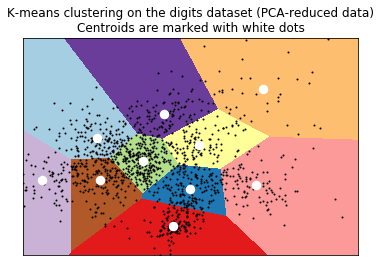

In [13]:
from sklearn import decomposition
# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = decomposition.PCA(n_components=2).fit(X_train)
reduced_X_train = pca.transform(X_train)
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will asign a color to each
x_min, x_max = reduced_X_train[:, 0].min() + 1, reduced_X_train[:, 0].max() - 1
y_min, y_max = reduced_X_train[:, 1].min() + 1, reduced_X_train[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

kmeans = cluster.KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_X_train)
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=plt.cm.Paired,
          aspect='auto', origin='lower')
#print reduced_X_train.shape

plt.plot(reduced_X_train[:, 0], reduced_X_train[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_

plt.scatter(centroids[:, 0], centroids[:, 1],
           marker='.', s=169, linewidths=3,
           color='w', zorder=10)

plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
         'Centroids are marked with white dots')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Affinity Propagation

A typical problem for clustering is that most methods require the number of clusters we want to identify. The general approach to solve this is to try different numbers and let an expert determine which works best using techniques such as dimensionality reduction to visualize clusters. There are also some methods that try to automatically calculate the number of clusters. Scikit-learn includes an implementation of Affinity Propagation, a method that looks for instances that are the most representative of others, and uses them to describe the clusters. Since scikit-learn uses the same function for every algorithm, we just have to fit the training set again:Try now using Affinity Propagation

In [16]:
# Affinity propagation
aff = cluster.AffinityPropagation()
aff.fit(X_train)
print (aff.cluster_centers_indices_.shape)




(112,)


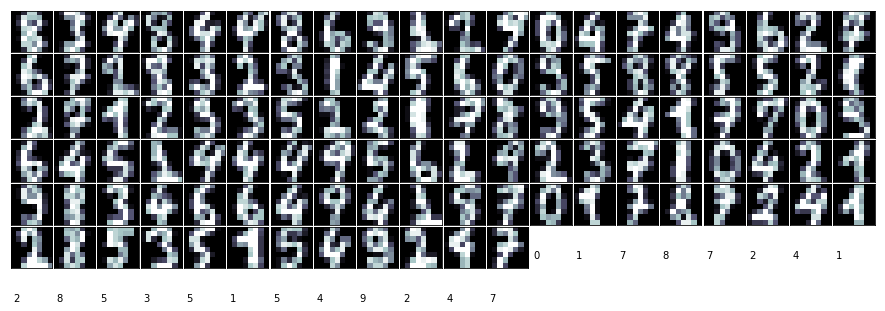

In [17]:
print_digits(images_train[aff.cluster_centers_indices_], y_train[aff.cluster_centers_indices_], max_n=aff.cluster_centers_indices_.shape[0])

### MeanShift

Yet another clustering method: MeanShift()

In [18]:
#MeanShift
ms = cluster.MeanShift()
ms.fit(X_train)
print (ms.cluster_centers_)

[[ 0.         -0.06920891 -0.00466096 ..., -0.00320756 -0.05788662
  -0.10216336]
 [ 0.         -0.33501649 -1.07875445 ..., -0.87280614 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649 -0.93131483 ...,  1.37732909  1.53211418
  -0.01675789]
 ..., 
 [ 0.         -0.33501649 -1.09493684 ..., -0.12952258 -0.5056698
  -0.19600752]
 [ 0.         -0.33501649  1.21914597 ...,  1.56568555  0.47246651
  -0.19600752]
 [ 0.         -0.33501649 -1.09493684 ..., -1.14664746 -0.5056698
  -0.19600752]]


In [25]:
print (ms.cluster_centers_.shape)


(18, 64)


## Mixture of Gaussian Models

Finally, we will try a probabilistic approach to clustering, using Gaussian Mixture Models (GMM). We will see, from a procedural view, that it is very similar to k-means, but their theoretical principles are quite different. GMM assumes that data comes from a mixture of finite Gaussian distributions with unknown parameters.

We will first use a heldout dataset to estimate covariance type (one of the method parameters)

In [26]:
from sklearn import mixture

# Define a heldout dataset to estimate covariance type
X_train_heldout, X_test_heldout, y_train_heldout, y_test_heldout = train_test_split(
        X_train, y_train,test_size=0.25, random_state=42)
for covariance_type in ['spherical','tied','diag','full']:
    gm=mixture.GMM(n_components=n_digits, covariance_type=covariance_type, random_state=42, n_init=5)
    gm.fit(X_train_heldout)
    y_pred=gm.predict(X_test_heldout)
    print ("Adjusted rand score for covariance={}:{:.2}".format(covariance_type, metrics.adjusted_rand_score(y_test_heldout, y_pred)))


c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarni

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

Adjusted rand score for covariance=spherical:0.49


c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

Adjusted rand score for covariance=tied:0.5


c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

Adjusted rand score for covariance=diag:0.4


c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

Adjusted rand score for covariance=full:0.4


c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

Train!

In [27]:
gm = mixture.GMM(n_components=n_digits, covariance_type='tied', random_state=42)
gm.fit(X_train)

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarni

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=1, n_iter=100, params='wmc', random_state=42,
  tol=0.001, verbose=0)

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


Addjusted rand score:0.65
Homogeneity score:0.75 
Completeness score: 0.8 
Confusion matrix
[[ 0  0 43  0  0  0  0  0  0  0]
 [19  0  0  7  0  0  0 11  0  0]
 [ 5  0  0 29  0  0  0  1  3  0]
 [ 2  0  0  0  0  0  0  0 44  0]
 [ 3 48  0  0  0  0  2  1  0  1]
 [ 0  0  0  0  1 56  0  0  2  0]
 [ 0  0  0  0 44  1  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  1  5]
 [27  0  0  0  0  1  0  0 10  0]
 [ 4  0  0  0  0  0  0  3 41  0]]


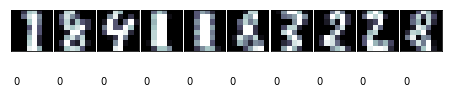

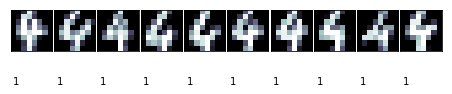

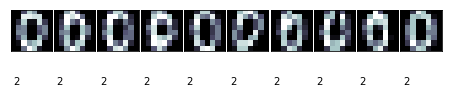

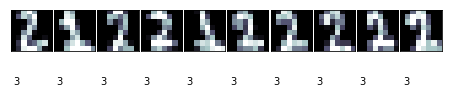

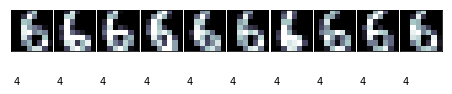

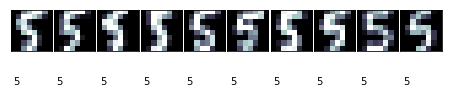

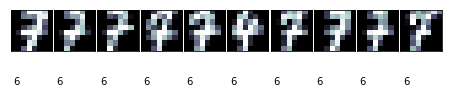

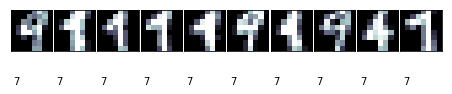

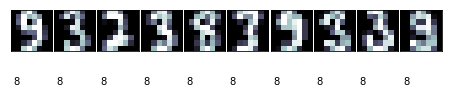

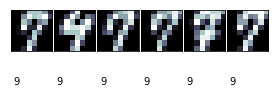

In [28]:
# Print train clustering and confusion matrix
y_pred = gm.predict(X_test)
print ("Addjusted rand score:{:.2}".format(metrics.adjusted_rand_score(y_test, y_pred)))
print ("Homogeneity score:{:.2} ".format(metrics.homogeneity_score(y_test, y_pred)) )
print ("Completeness score: {:.2} ".format(metrics.completeness_score(y_test, y_pred)))
for i in range(10):
     print_cluster(images_test, y_pred, i)
print ("Confusion matrix")
print (metrics.confusion_matrix(y_test, y_pred))

Predict!

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecati

c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
c:\venvs\scikit-learn-book\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Fu

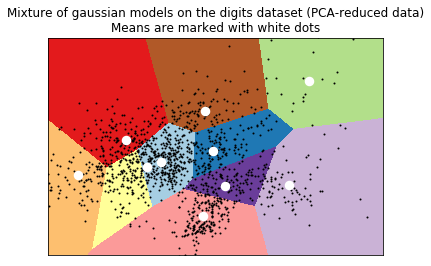

In [29]:
pl=plt
from sklearn import decomposition
# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = decomposition.PCA(n_components=2).fit(X_train)
reduced_X_train = pca.transform(X_train)
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will asign a color to each
# Taken from 
x_min, x_max = reduced_X_train[:, 0].min() + 1, reduced_X_train[:, 0].max() - 1
y_min, y_max = reduced_X_train[:, 1].min() + 1, reduced_X_train[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

gm.fit(reduced_X_train)
#print np.c_[xx.ravel(),yy.ravel()]
Z = gm.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
pl.figure(1)
pl.clf()
pl.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=pl.cm.Paired,
          aspect='auto', origin='lower')
#print reduced_X_train.shape

pl.plot(reduced_X_train[:, 0], reduced_X_train[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = gm.means_

pl.scatter(centroids[:, 0], centroids[:, 1],
           marker='.', s=169, linewidths=3,
           color='w', zorder=10)

pl.title('Mixture of gaussian models on the digits dataset (PCA-reduced data)\n'
         'Means are marked with white dots')
pl.xlim(x_min, x_max)
pl.ylim(y_min, y_max)
pl.xticks(())
pl.yticks(())
pl.show()